# Snake AI

A deep-learning agent learns how to play a snake from scratch

In [12]:
import numpy as np

import gym
from gym import error, spaces, utils
from gym.utils import seeding

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy

import warnings
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Class Game

Here we define the Game environment 

In [13]:
n_pixels=20

class Game(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        npx_x=n_pixels # the board is an n_pixels x n_pixels grid 
        npx_y=n_pixels
        
        self.game_over=0 # flag indicating when the game is over
        
        self.score=0
        
        self.npx_x=npx_x
        self.npx_y=npx_y
        
        self.pixels=np.zeros((npx_x,npx_y)) # each pixel takes either value 0 (empty), 1 (snake body), 2 (fruit), or 3 (snake head)
        
        self.snake=[] # the snake is a list of cells
        self.snake.append(np.array([0,0]))
        self.snake.append(np.array([0,1]))
        self.len=2
        
        for i in range(self.len-1):
            self.pixels[self.snake[i][0],self.snake[i][1]]=1
        self.pixels[self.snake[-1][0],self.snake[-1][1]]=3
        
        self.dir=1 # 0 up, 1 right, 2 down, 3 left
        
        self.is_fruit=0 # flag indicating if there is a fruit on the board
        self.fruit_pos=np.array([0,0])
        self.spawn_fruit()
        
        self.count_from_fruit=0 # number of frames since the last time the snake ate
        
    def spawn_fruit(self,fruit_x=-1,fruit_y=-1):
        # method spawning a fruit somewhere in the board. 
        # arguments:
        # fruit_x (int): fruit position along the x direction. -1 corresponds to a random position.
        # fruit_y (int): fruit position along the y direction. -1 corresponds to a random position.
        
        if self.is_fruit==1:
            warnings.warn("Trying to spawn fruit, but there exist a fruit already")
            
        else:
            
            if fruit_x>=0 and fruit_x < npx_x and fruit_y>=0 and fruit_y<npx_y:
                self.fruit_pos=np.array([fruit_x,fruit_y])
                self.pixels[self.fruit_pos[0],self.fruit_pos[1]]=2

                self.is_fruit=1
                
            elif fruit_x==-1 and fruit_y==-1:
        
                count_black=self.npx_y-np.count_nonzero(self.pixels,axis=1)
                
                x_fruit=np.random.choice(range(self.npx_x),p=count_black/sum(count_black))
                count_black=(self.pixels[x_fruit,:]==0).astype(int)
                y_fruit=np.random.choice(range(self.npx_y),p=count_black/sum(count_black))

                self.fruit_pos=np.array([x_fruit,y_fruit])
                self.pixels[self.fruit_pos[0],self.fruit_pos[1]]=2

                self.is_fruit=1
                
            else:
                warnings.warn("Trying to spawn fruit outside of bounds")
        
    def move_step(self):
        # Moves the snake by 1 pixel along the direction self.dir
        
        head=self.snake[-1] # current position of the snake head
        if self.dir==0:
            newhead=head+np.array([-1,0])
        elif self.dir==1:
            newhead=head+np.array([0,1])
        elif self.dir==2:
            newhead=head+np.array([1,0])
        elif self.dir==3:
            newhead=head+np.array([0,-1])
        # newhead: next position of the snake head    
            
        # if newhead is out of the board or is located on a body part, set game_over to 1 and give the agent a negative reward   
        if newhead[0]<0 or newhead[0]>=self.npx_x or newhead[1]<0 or newhead[1]>=self.npx_y or self.pixels[newhead[0],newhead[1]]==1:
            self.game_over=1
            self.score+=self.count_from_fruit
            
            self.reward-=100
            
        # if newhead is located on the fruit, increase the size of the snake by updating the snake head   
        elif self.pixels[newhead[0],newhead[1]]==2:
            self.snake.append(newhead)
            self.len+=1
            self.is_fruit=0
            self.score+=1100-self.count_from_fruit
            self.count_from_fruit=0
            self.pixels[newhead[0],newhead[1]]=3
            self.pixels[self.snake[-2][0],self.snake[-2][1]]=1
            
            ## uncomment to avoid snake growth
            #self.pixels[self.snake[0][0],self.snake[0][1]]=0 # delete this line to make snake grow
            #del self.snake[0] # delete this line to make snake grow
            
            self.reward+=1000
            
        # otherwise remove the tail and add the new head   
        else:
            self.snake.append(newhead)
            self.pixels[self.snake[-1][0],self.snake[-1][1]]=3
            self.pixels[self.snake[-2][0],self.snake[-2][1]]=1
            self.pixels[self.snake[0][0],self.snake[0][1]]=0
            del self.snake[0]
            
    def set_direction(self,dir):
        # Sets the new direction for the snake
        # Arguments:
        # dir: int: desired direction. Up = 0, right = 1, down = 2, left=3
        
        assert(dir>=-1)
        assert(dir<=3)
        
        # forbidden_dir corresponds to the backward direction. If dir == forbidden_dir, the direction will not be updated
        forbidden_dir=self.snake[-2]-self.snake[-1]
        
        if not (forbidden_dir-np.array([-1,0])).any():
            if dir != 0 and dir!=-1:
                self.dir=dir
        elif not (forbidden_dir-np.array([0,1])).any():
            if dir != 1 and dir!=-1:
                self.dir=dir
        elif not (forbidden_dir-np.array([1,0])).any():
            if dir != 2 and dir!=-1:
                self.dir=dir
        elif not (forbidden_dir-np.array([0,-1])).any():
            if dir != 3 and dir!=-1:
                self.dir=dir
        else:
            warning.warn("Problem with forbidden_dir")
            
    def time_step(self):
        # defines the actions undertaken by the game during each frame
        
        # respawn the fruit
        if self.is_fruit==0:
            self.spawn_fruit()
        
        #move the snake
        self.move_step()
        self.count_from_fruit+=1
        
        # the snake starves to death if it hasn't eaten for 100 frames
        if self.count_from_fruit>=100:
            self.game_over=1
            self.score+=self.count_from_fruit
            
            self.reward-=100
        
    def step(self,direction):
        # defines the actions undertaken by the agent during each frame
        # Arguments:
        # direction: int: desired next direction. Up = 0, right = 1, down = 2, left=3
        
        self.reward=0
        
        # sets the new direction
        self.set_direction(direction)
            
        # evolves the game for 1 frame    
        self.time_step()
        
        info={'items':[]}
        
        return [self.get_input(), self.reward, self.game_over, info]
    
    def render(self,mode):
        # renders the game 
        
        pl.clf()
        pl.imshow(self.pixels,vmin=0,vmax=3,cmap='gist_ncar')
        pl.axis('off')
        display.clear_output(wait=True)
        display.display(pl.gcf())
        
    def reset(self):
        # Resets the game to its initial state
        
        npx_x=n_pixels
        npx_y=n_pixels
        
        self.game_over=0
        
        self.score=0
        
        self.npx_x=npx_x
        self.npx_y=npx_y
        
        self.pixels=np.zeros((npx_x,npx_y)) # 0 nothing, 1 snake, 2 fruit, 3 head
        
        self.snake=[]
        self.snake.append(np.array([0,0]))
        self.snake.append(np.array([0,1]))
        self.len=2
        
        for i in range(self.len-1):
            self.pixels[self.snake[i][0],self.snake[i][1]]=1
        self.pixels[self.snake[-1][0],self.snake[-1][1]]=3
        
        self.dir=1 # 0 up, 1 right, 2 down, 3 left
        
        self.is_fruit=0
        self.fruit_pos=np.array([0,0])
        self.spawn_fruit()
        
        self.count_from_fruit=0
        
        return self.get_input()
   
    def get_input(self):
        # returns the information provided to the RL agent as a list of 24 int numbers. Along 8 directions, returns the distance from the snake head to the wall, its body, and the fruit
        
        input=[]
        pixels=self.pixels[self.snake[-1][0]::-1,self.snake[-1][1]] # up
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        pixels=np.diagonal(np.flipud(self.pixels[:self.snake[-1][0]+1,self.snake[-1][1]:])) # up right
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        pixels=self.pixels[self.snake[-1][0],self.snake[-1][1]:] # right
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        pixels=np.diagonal(self.pixels[self.snake[-1][0]:,self.snake[-1][1]:]) # down right
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        pixels=self.pixels[self.snake[-1][0]:,self.snake[-1][1]] # down
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        pixels=np.diagonal(np.fliplr(self.pixels[self.snake[-1][0]:,:self.snake[-1][1]+1])) # down left
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        pixels=self.pixels[self.snake[-1][0],self.snake[-1][1]::-1] # left
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        pixels=np.diagonal(np.flipud(np.fliplr(self.pixels[:self.snake[-1][0]+1,:self.snake[-1][1]+1]))) # up left
        wall, body, fruit = self.search_wall_body_fruit(pixels)
        input.append(wall)
        input.append(body)
        input.append(fruit)
        
        return input

    def search_wall_body_fruit(self,pixels):
        # returns:
        # wall: distance to the wall, given by the size of pixels
        # body: distance to the snake body, corresponding to the first index with pixels[index]==1 (default value = n_pixels)
        # fruit: distance to the snake body, corresponding to the first index with pixels[index]==2 (default value = 2*n_pixels)
        
        pixsize=pixels.size
        
        wall=pixsize-1
        
        body=self.npx_x
        fruit= 2*self.npx_x
        
        count=-1
        
        while pixels.size>0:
            if body==self.npx_x and pixels[0]==1:
                body=count
            elif fruit==2*self.npx_x and pixels[0]==2:
                fruit=count
            
            count+=1
            pixels=np.delete(pixels,0)
            
        return wall, body, fruit    

The environment given to the RL agent is then an instance of the game

In [3]:
env = Game()

## Deep-learning architecture

We use the keras library, and use a 3-layer neural network to approximate the Q-function 

In [14]:
model = Sequential()
model.add(Flatten(input_shape=(1,24)))
model.add(Dense(units=18))
model.add(Activation('relu'))
model.add(Dense(units=18))
model.add(Activation('relu'))
model.add(Dense(units=4))

The agent is a DQNAgent, which uses the neural network model to chose the direction at each frame

In [5]:
nb_actions = 4 # number of actions the agent can take, corresponding to the direction chosen at each time step

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=500,
target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

The agent can then be trained (this may take a few hours)

In [93]:
#dqn.fit(env, nb_steps=1000000, visualize=False,verbose=0)
#dqn.save_weights("savefile")

Here is the agent in action! Feel free to change the seed 

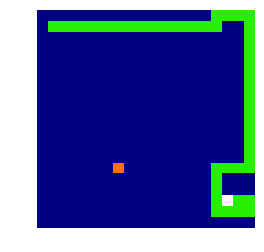

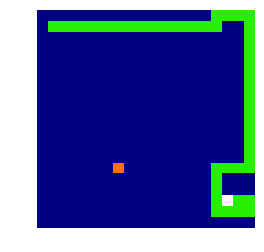

In [20]:
np.random.seed(3)

dqn.load_weights("keras_20x20") # weights learned from playing on a 20 x 20 grid from scratch for a few hours

obs=env.reset()
dones=False

fig, ax = plt.subplots()
while not dones:
    action = dqn.model.predict(np.reshape(obs,[1,1,24]))
    obs, rewards, dones, info = env.step(np.argmax(action))
    env.render(0)